# Main Procedure


Conclusion 1: Comparing with `Main_Procedure_Train10000`,`Main_Procedure_Train100`, we can find that the larger size of training data, the worse effect of multi_step pu learning using only one test dataset  
By experiment, I find the numbers of reliable negatives is much higher than the true outliers in the test data.
When the size of training data is larger, OCC works well, then there are less reliable negatives(although still much higher than the num of true outliers).  

### Setup

In [89]:
# This helps when you're loading functions  defined in an external script (if the script is updated while the notebook is running)
%load_ext autoreload 
%autoreload 2

import numpy as np
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from sklearn.decomposition import PCA
from math import sqrt
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.multitest import multipletests
import copy

import sys
sys.path.append("..")

from mypackage.data_models import generate_data_uniform_plus_normal
from mypackage.PUL import compute_pu_scores, prepare_pu_score_matrices, adjust_proportions
from mypackage.MAMCOD_procedure import compute_MAMCOD_conformal_pv, compute_fdr_power

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Generation

In [95]:
np.random.seed(100)
# Generate data
K = 2
dim = 50
means = [-1, 1]
radius = 4
a_signal = 4

# Training data
n_in_train = [1980, 20]

# Calibration data (Here callibrariton data has no effect if not using conformal inference)
n_in_cal = [1000, 1000]

# Test data (Unlabeled Data)
n_in_test = [900, 100]
n_out_test = 200
n_test = sum(n_in_test) + n_out_test

# Data Generation
X_train, Y_train = generate_data_uniform_plus_normal(K, n_in_train, 0, dim, means, radius, a_signal)
X_cal, Y_cal = generate_data_uniform_plus_normal(K, n_in_cal, 0, dim, means, radius, a_signal)
X_test, Y_test = generate_data_uniform_plus_normal(K, n_in_test, n_out_test, dim, means, radius, a_signal)

### Compute the MAMCOD p-values Using PU Learning

In [96]:
# Define machine learning models
from sklearn.svm import SVC, OneClassSVM
from sklearn.ensemble import RandomForestClassifier

binary_classifier = SVC(C=1, probability=True)
oneclass_classifier = OneClassSVM(gamma='auto')

# Compute conformity scores
scores_cal, scores_test,_ = compute_pu_scores(
    K, X_train, Y_train, X_cal, Y_cal, X_test, binary_classifier,
    oneclass_classifier= oneclass_classifier, multi_step=True)

scores_cal_mat, scores_test_mat = prepare_pu_score_matrices(K, n_in_cal, n_test, scores_cal, scores_test)

# Compute adjusted proportions in training data
X_train_subsample, Y_train_subsample = adjust_proportions(X_train, Y_train, X_cal, X_test, oneclass_classifier, K, method='subsample')

# Compute PU scores
scores_cal_subsample, scores_test_subsample, _ = compute_pu_scores(
    K, X_train_subsample, Y_train_subsample, X_cal, Y_cal, X_test, binary_classifier,
    oneclass_classifier=oneclass_classifier, multi_step=True)

scores_cal_mat_subsample, scores_test_mat_subsample = prepare_pu_score_matrices(K, n_in_cal, n_test, scores_cal_subsample, scores_test_subsample)

# Compute MAMCOD conformal p-values
MAMCOD_pv = compute_MAMCOD_conformal_pv(K, n_in_cal, scores_cal_mat, scores_test_mat, is_high_score_inlier = False)
MAMCOD_pv_subsample = compute_MAMCOD_conformal_pv(K, n_in_cal, scores_cal_mat_subsample, scores_test_mat_subsample, is_high_score_inlier = False)

### Compute FDR and Power by BH procedure

In [97]:
fdr, power = compute_fdr_power(MAMCOD_pv, Y_test, alpha = 0.1)
fdr_subsample, power_subsample = compute_fdr_power(MAMCOD_pv_subsample, Y_test, alpha = 0.1)

print("FDR:", fdr)
print("Power:", power)
print("FDR_subsample", fdr_subsample)
print("power_subsample", power_subsample)

FDR: 0
Power: 0.0
FDR_subsample 0.0
power_subsample 0.97


### Plot

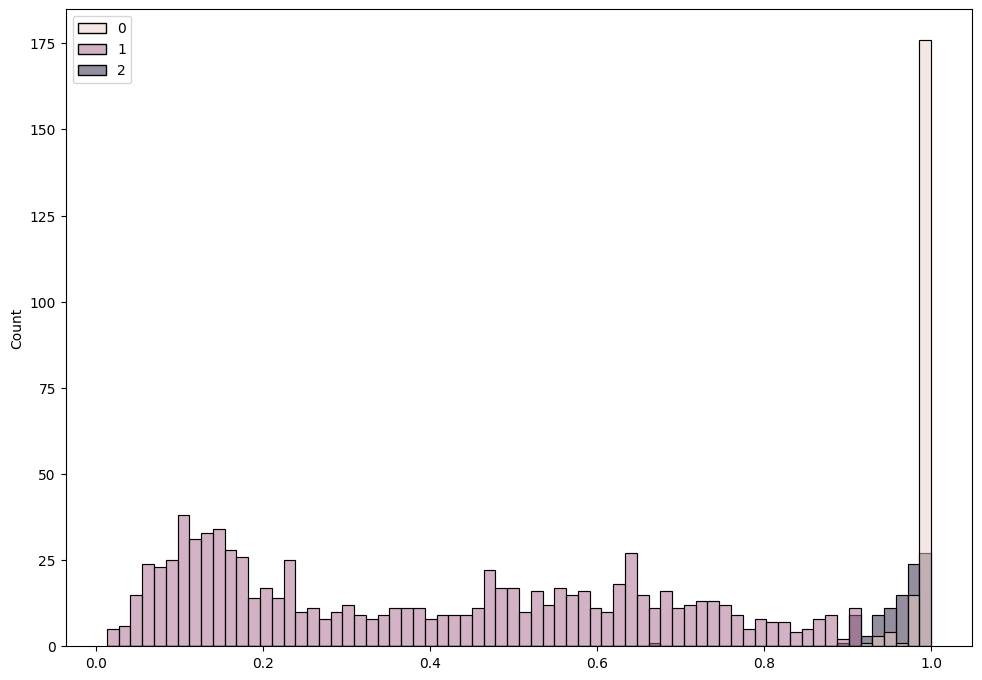

In [98]:
# Plot the conformity scores
rcParams['figure.figsize'] = 11.7,8.27

sns.histplot(x=scores_test, hue=Y_test, bins=70)
plt.show()

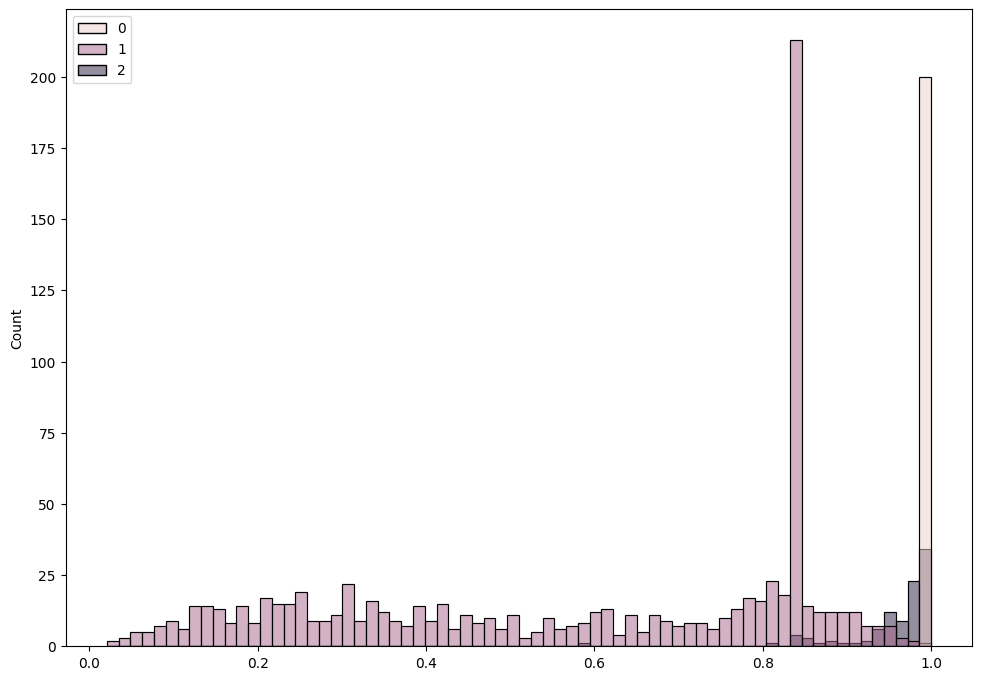

In [99]:
# Plot the conformity scores
rcParams['figure.figsize'] = 11.7,8.27

sns.histplot(x=scores_test_subsample, hue=Y_test, bins=70)
plt.show()